# TransResUNet: Improving U-Net Architecture for Robust Lungs Segmentation in Chest X-rays

Reference paper can be accessed at - https://www.researchgate.net/publication/342038283_TransResUNet_Improving_U-Net_Architecture_for_Robust_Lungs_Segmentation_in_Chest_X-rays

In [1]:
# Importing required packages
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# 1. TransResUNet - Model Defination

* ## Residual Path

In [2]:
def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)
    
    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

* ## Decoder Block

In [3]:
def decoder_block(inputs, mid_channels, out_channels):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # Upsampling (nearest neighbor interpolation) layer
    db = UpSampling2D(size=(2, 2))(inputs)
    # First conv2D layer 
    db = Conv2D(mid_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db

* ## Main Architecture

In [4]:
def TransResUNet(input_size=(512, 512, 1)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)
    inp = inputs
    input_shape = input_size
    
    # Handling input channels 
    # input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(inputs)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = inputs
        input_shape = input_size

    # VGG16 with imagenet weights
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc3)
    center = decoder_block(center, 512, 256)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, center], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)
   

    # Output
    out = Conv2D(1, 1)(dec1)
    out = Activation('sigmoid')(out)  
    
    # Final model
    model = Model(inputs=[inputs], outputs=[out])
    
    return model

* ## Model Summary

In [5]:
model = TransResUNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 3)  6           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

# 2. Data preparation
Reference: https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen

Prepare the input segmentation directory structure.

In [6]:
# mkdir ../input/segmentation
# mkdir ../input/segmentation/test
# mkdir ../input/segmentation/train
# mkdir ../input/segmentation/train/augmentation
# mkdir ../input/segmentation/train/image
# mkdir ../input/segmentation/train/mask
# mkdir ../input/segmentation/train/dilate

Define appropriate constants for directory paths and training parameters

In [7]:
INPUT_DIR = os.path.join("..", "input")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary-chest-xray-abnormalities")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles", \
                                  "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "shcxr-lung-mask", "mask", "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, \
                                    "Montgomery", "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                        "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                         "ManualMask", "rightMask")

DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=4

1. Combine left and right lung segmentation masks of Montgomery chest x-rays
1. Resize images to 512x512 pixels
1. Dilate masks to gain more information on the edge of lungs
1. Split images into training and test datasets
1. Write images to /segmentation directory

In [8]:
import random
random.seed(91)
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
montgomery_left_mask_dir_temp = random.sample(montgomery_left_mask_dir, len(montgomery_left_mask_dir))
montgomery_test = montgomery_left_mask_dir_temp[0:41]
montgomery_train= montgomery_left_mask_dir_temp[41:]

In [9]:
skip_this = True

if not skip_this:
    for left_image_file in tqdm(montgomery_left_mask_dir):
        base_file = os.path.basename(left_image_file)
        image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
        right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

        image = cv2.imread(image_file)
        left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
        right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image, (512, 512))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        left_mask = cv2.resize(left_mask, (512, 512))
        right_mask = cv2.resize(right_mask, (512, 512))
        
        mask = np.maximum(left_mask, right_mask)
        mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
        
        if (left_image_file in montgomery_train):
            cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                        image)
            cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                        mask)
            cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                        mask_dilate)
        else:
            filename, fileext = os.path.splitext(base_file)
            cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                        image)
            cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                    "%s_mask%s" % (filename, fileext)), mask)
            cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                    "%s_dilate%s" % (filename, fileext)), mask_dilate)

Define some useful functions to display images with segmentation as overlays

In [10]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

Show some Montgomery chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

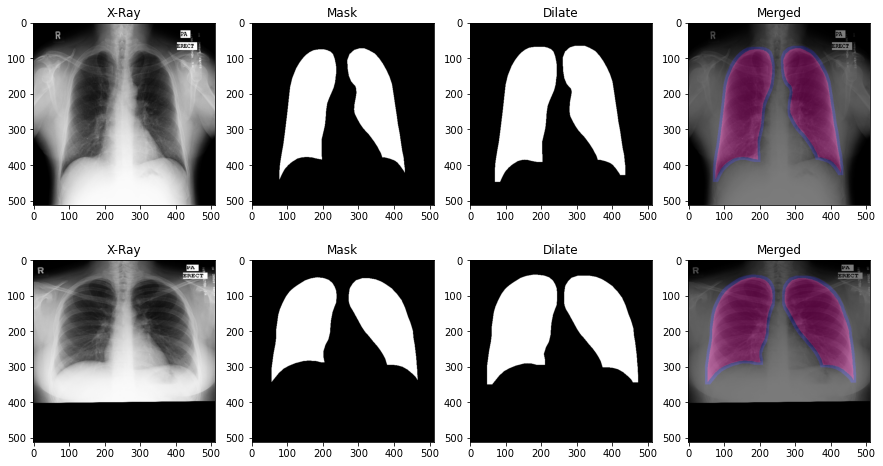

In [11]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
plt.set_cmap('gray')

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

Print the count of images and segmentation lung masks available to test and train the model

In [12]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(97, 123, 97, 97)

# 3. Segmentation training

References: https://github.com/zhixuhao/unet/, https://github.com/jocicmarko/ultrasound-nerve-segmentation

Data augmentation helper function for training the net

In [13]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

Metric functions

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Helper functions to load test chest x-ray images

In [15]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

Select test and validation files

In [16]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

In [17]:
test_x = []
for i in test_files:
    test_x.append(test_load_image(i, target_size=(512, 512)))
    
test_x = np.array(test_x)
val_x = test_x[27:,0,:,:]
test_x = test_x[:27,0,:,:]
val_x.shape

(14, 512, 512, 1)

In [18]:
test_y = []
for i in test_files:
    test_y.append(test_load_image(add_suffix(i, "dilate"), target_size=(512, 512)))

test_y = np.array(test_y)
val_y = test_y[27:,0,:,:]
test_y = test_y[:27,0,:,:]
val_y.shape

(14, 512, 512, 1)

Configuring the hyperparameter and Training 

In [19]:
BATCH_SIZE = 1
EPOCH = 5

In [20]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = TransResUNet()

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('transresunet_seg.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCH, 
                              callbacks=[model_checkpoint],
                              validation_data = (val_x, val_y))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 512, 512, 3)  6           ['input_3[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['conv2d_21[0][0]']              
                                )                                                                 
                                                                                            

D:\Programy\conda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 256, 64  147520      ['conv2d_26[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 512, 512, 32  9248        ['add_9[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 512, 512, 32  1056        ['add_9[0][0]']                  
                                )                                                                 
                                                                                                  
 concatena

C:\Users\Kuba\AppData\Local\Temp\ipykernel_6536\3410841947.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/5


Error: Canceled future for execute_request message before replies were done

Show some results from model fitting history

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['dice_coef']
validation_accuracy = history.history['val_dice_coef']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Dice Coef', 'Validation Dice Coef'])

Make lung segmentation predictions

In [ ]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

# 4. Test Set Evaluation

In [ ]:
model.evaluate(test_x,test_y, BATCH_SIZE)